# Analysis of Protein Content, Recipe Ratings, and Prediction of Calorie Amounts

**Name(s)**: Nathan Joseph

**Website Link**: [(Website Link)](https://n2joseph4.github.io/protein_content-recipe_ratings-and-predicted-calories/)

In [1]:
# Imports

import pandas as pd
import numpy as np
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
pd.options.plotting.backend = 'plotly'
from scipy.stats import ks_2samp
!pip install tabulate

from dsc80_utils import * # Feel free to uncomment and use this.

## Step 1: Introduction

In [2]:
# Read in both files and merged appropriately

recipes = pd.read_csv('data/RAW_recipes.csv')
ratings = pd.read_csv('data/RAW_interactions.csv')
df1 = recipes.merge(ratings, left_on='id', right_on= 'recipe_id', how = 'left')
df1['rating'] = df1['rating'].replace(0, np.nan)
ser = df1.groupby('name')['rating'].mean()
df = df1.merge(ser, left_on= 'name', right_on='name', how='left')
df['rating'] = df['rating_x']
df = df.drop('rating_x', axis=1)
df['average rating per recipe'] = df['rating_y']
df = df.drop('rating_y', axis=1)
# DATA SCIENCE QUESTION
print('Data Science Question: Do Recipes for Foods with High Protein Content as Measured by Higher Percent Daily Value Have Higher Ratings?')

Data Science Question: Do Recipes for Foods with High Protein Content as Measured by Higher Percent Daily Value Have Higher Ratings?


## Step 2: Data Cleaning and Exploratory Data Analysis

In [3]:
# TODO

In [4]:
# DATA CLEANING: Converted date column to datetime objects

df['date']=pd.to_datetime(df['date']) # Data cleaning HERE
df = df.dropna(subset=['date'])
df

,name,id,minutes,contributor_id,...,date,review,rating,average rating per recipe
0,1 brownies in the world best ever,333281,40,985201,...,2008-11-19,"These were pretty good, but took forever to ba...",4.0,4.0
1,1 in canada chocolate chip cookies,453467,45,1848091,...,2012-01-26,Originally I was gonna cut the recipe in half ...,5.0,5.0
2,412 broccoli casserole,306168,40,50969,...,2008-12-31,This was one of the best broccoli casseroles t...,5.0,5.0
...,...,...,...,...,...,...,...,...,...
234426,cookies by design sugar shortbread cookies,298509,20,506822,...,2008-06-19,This recipe tastes nothing like the Cookies by...,1.0,3.0
234427,cookies by design sugar shortbread cookies,298509,20,506822,...,2010-02-08,"yummy cookies, i love this recipe me and my sm...",5.0,3.0
234428,cookies by design sugar shortbread cookies,298509,20,506822,...,2014-11-01,I work at a Cookies By Design and can say this...,NaN,3.0


In [5]:
# DATA CLEANING: Creating individual columns for each of items inside the nutrition column and kept missing values for Step 4

df_missing_vals = df[df['nutrition'].notna()].copy()
df_nutr = df_missing_vals['nutrition'].str.strip('[]').str.split(',', expand=True).apply(pd.to_numeric)
df_nutr.columns = ['calories','total_fat_PDV','sugar_PDV','sodium_PDV','protein_PDV','saturated_fat_PDV','carbs_PDV'] # Data cleaning HERE
df_missing_vals = pd.concat([df_missing_vals.drop('nutrition', axis=1), df_nutr], axis=1)
pdv_cols = ['total_fat_PDV','sugar_PDV','sodium_PDV','protein_PDV','saturated_fat_PDV','carbs_PDV']
check = (df_missing_vals[pdv_cols] >= 0) & (df_missing_vals[pdv_cols] <= 300) # Data cleaning HERE
df_missing_vals = df_missing_vals[check.all(axis=1)]
df_missing_vals

,name,id,minutes,contributor_id,...,sodium_PDV,protein_PDV,saturated_fat_PDV,carbs_PDV
0,1 brownies in the world best ever,333281,40,985201,...,3.0,3.0,19.0,6.0
1,1 in canada chocolate chip cookies,453467,45,1848091,...,22.0,13.0,51.0,26.0
2,412 broccoli casserole,306168,40,50969,...,32.0,22.0,36.0,3.0
...,...,...,...,...,...,...,...,...,...
234426,cookies by design sugar shortbread cookies,298509,20,506822,...,4.0,4.0,11.0,6.0
234427,cookies by design sugar shortbread cookies,298509,20,506822,...,4.0,4.0,11.0,6.0
234428,cookies by design sugar shortbread cookies,298509,20,506822,...,4.0,4.0,11.0,6.0


In [6]:
# DATA CLEANING: Handling Missing Values

dataframe_final = df_missing_vals.dropna()
dataframe_final

,name,id,minutes,contributor_id,...,sodium_PDV,protein_PDV,saturated_fat_PDV,carbs_PDV
0,1 brownies in the world best ever,333281,40,985201,...,3.0,3.0,19.0,6.0
1,1 in canada chocolate chip cookies,453467,45,1848091,...,22.0,13.0,51.0,26.0
2,412 broccoli casserole,306168,40,50969,...,32.0,22.0,36.0,3.0
...,...,...,...,...,...,...,...,...,...
234425,cookies by design cookies on a stick,298512,29,506822,...,11.0,7.0,21.0,9.0
234426,cookies by design sugar shortbread cookies,298509,20,506822,...,4.0,4.0,11.0,6.0
234427,cookies by design sugar shortbread cookies,298509,20,506822,...,4.0,4.0,11.0,6.0


In [7]:
dataframe_final.columns

Index(['name', 'id', 'minutes', 'contributor_id', 'submitted', 'tags',
       'n_steps', 'steps', 'description', 'ingredients', 'n_ingredients',
       'user_id', 'recipe_id', 'date', 'review', 'rating',
       'average rating per recipe', 'calories', 'total_fat_PDV', 'sugar_PDV',
       'sodium_PDV', 'protein_PDV', 'saturated_fat_PDV', 'carbs_PDV'],
      dtype='object')

In [8]:
print(dataframe_final[['name']].head().to_markdown(index=False))
# ,'rating', 'average rating per recipe', 'protein_PDV', 'calories', 'date'

| name                                 |
|:-------------------------------------|
| 1 brownies in the world    best ever |
| 1 in canada chocolate chip cookies   |
| 412 broccoli casserole               |
| 412 broccoli casserole               |
| 412 broccoli casserole               |


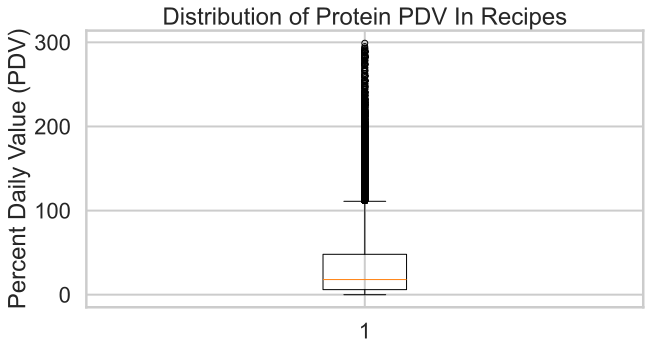

In [11]:
# UNIVARIATE PLOT 1: to show distribution of protein PDV in recipes 

# maybe check dropna

step_2_visual_df1 = dataframe_final.copy()
plt.boxplot(step_2_visual_df1['protein_PDV'])
plt.ylabel('Percent Daily Value (PDV)')
plt.title('Distribution of Protein PDV In Recipes')
plt.show()

In [ ]:
import plotly.express as px

step_2_visual_df1 = dataframe_final.copy()
fig = px.box(
    step_2_visual_df1,
    y='protein_PDV',
    title='Distribution of Protein PDV in Recipes',
    labels={'protein_PDV': 'Percent Daily Value (PDV)'}
)


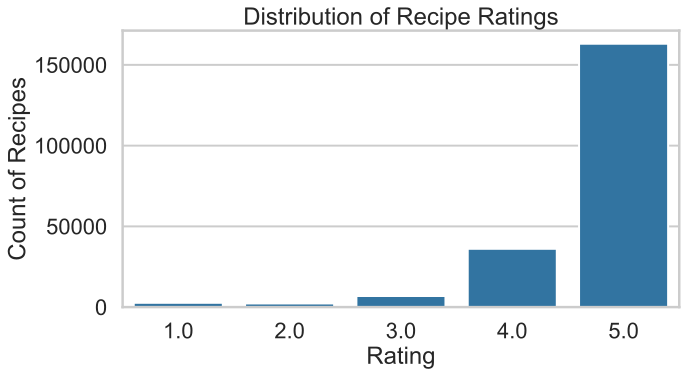

In [8]:
# UNIVARIATE PLOT 2: to show distribution of recipe ratings

step_2_visual_df2 = dataframe_final.copy()

sns.countplot(data=step_2_visual_df2, x='rating')
plt.xlabel('Rating')
plt.ylabel('Count of Recipes')
plt.title('Distribution of Recipe Ratings')
plt.show()

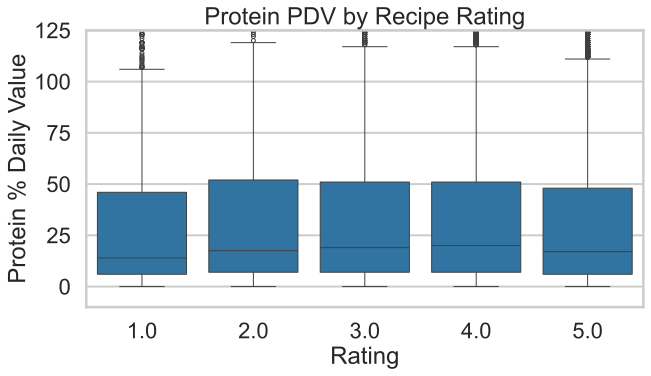

In [9]:
# BIVARIATE PLOT 1: 

step_2_visual_df3 = dataframe_final.copy()
sns.boxplot(data=step_2_visual_df3, x='rating', y='protein_PDV', flierprops={'markersize': 4})
plt.xlabel('Rating')
plt.ylabel('Protein % Daily Value')
plt.title('Protein PDV by Recipe Rating')
plt.ylim(-10, 125) # Y-axis limited to 0–125% for clarity and thus extreme outliers beyond this range are not shown.
plt.show()

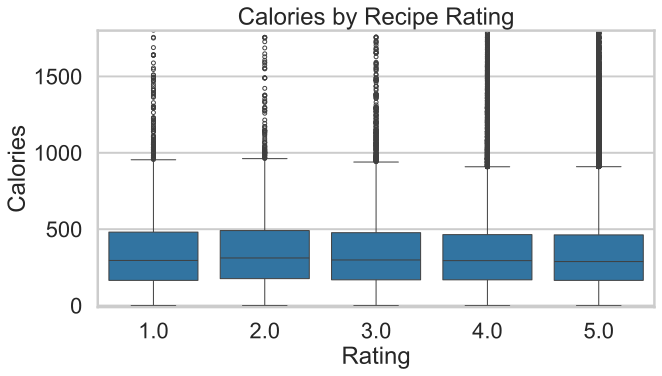

In [10]:
# BIVARIATE PLOT 2:
step_2_visual_df3 = dataframe_final.copy()
sns.boxplot(data=step_2_visual_df3, x='rating', y='calories', flierprops={'markersize': 4})
plt.xlabel('Rating')
plt.ylabel('Calories')
plt.title('Calories by Recipe Rating')
plt.ylim(-10, 1800) # Y-axis limited to 0–1800 cal for clarity and thus extreme outliers beyond this range are not shown
plt.show()

In [11]:
# Interesting Aggregates Pivot Table

step_2_pivot = dataframe_final.copy()

pivot = step_2_pivot.pivot_table(
    values='protein_PDV',
    index='rating',
    aggfunc=['count', 'median', 'mean', 'std'],
    fill_value=0
)
pivot

,count,median,mean,std
,protein_PDV,protein_PDV,protein_PDV,protein_PDV
rating,,,,
1.0,2672,14.0,31.59,38.80
2.0,2262,17.5,33.06,36.11
3.0,6900,19.0,33.16,35.62
4.0,36099,20.0,32.61,33.84
5.0,163084,17.0,30.86,34.43


## Step 3: Assessment of Missingness

In [12]:
# TODO

In [13]:
# Missingness Dependency

def test_mar_ks(df, target_col, obs_col, n_repetitions=500, random_state=None):
    if random_state is not None:
        np.random.seed(random_state)
    
    # Create missing indicator
    df = df.copy()
    df['missing_indicator'] = df[target_col].isna().astype(int)
    
    # Extract groups
    observed_values = df.loc[df['missing_indicator'] == 0, obs_col].values
    missing_values = df.loc[df['missing_indicator'] == 1, obs_col].values
    
    # observed KS
    observed_ks = ks_2samp(observed_values, missing_values).statistic
    
    # Concatenate data for permutation
    all_values = np.concatenate([observed_values, missing_values])
    group_labels = np.array([0]*len(observed_values) + [1]*len(missing_values))
    
    ks_stats = []
    for _ in range(n_repetitions):
        shuffled_labels = np.random.permutation(group_labels)
        group0 = all_values[shuffled_labels == 0]
        group1 = all_values[shuffled_labels == 1]
        ks_stat = ks_2samp(group0, group1).statistic
        ks_stats.append(ks_stat)
    
    ks_stats = np.array(ks_stats)
    p_value = np.mean(ks_stats >= observed_ks)
    
    print(f"Observed KS statistic: {observed_ks:.4f}")
    print(f"Permutation-based p-value: {p_value:.4f}")
    if p_value < 0.05:
        print("→ Missingness in target_col likely depends on obs_col (MAR plausible).")
    else:
        print("→ No strong evidence that missingness depends on obs_col.")
    
    return p_value
p1 = test_mar_ks(df_missing_vals, target_col='average rating per recipe', obs_col='protein_PDV', n_repetitions=1000, random_state=42) #MCAR
p3 = test_mar_ks(df_missing_vals, target_col='description', obs_col='calories', n_repetitions=1000, random_state=42) #MAR


Observed KS statistic: 0.0235
Permutation-based p-value: 0.0760
→ No strong evidence that missingness depends on obs_col.
Observed KS statistic: 0.1502
Permutation-based p-value: 0.0140
→ Missingness in target_col likely depends on obs_col (MAR plausible).


/var/folders/2h/52ll83px0mv470kx3j0vrlrm0000gn/T/ipykernel_18419/2612809955.py:14: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




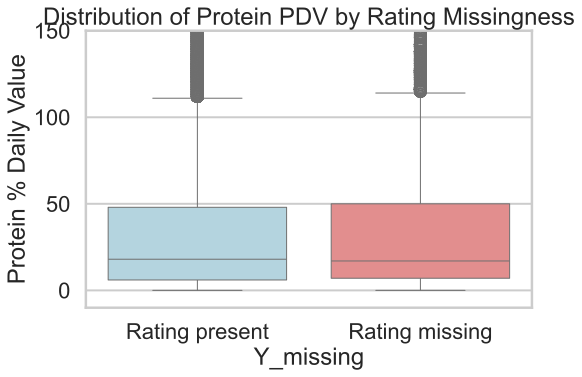

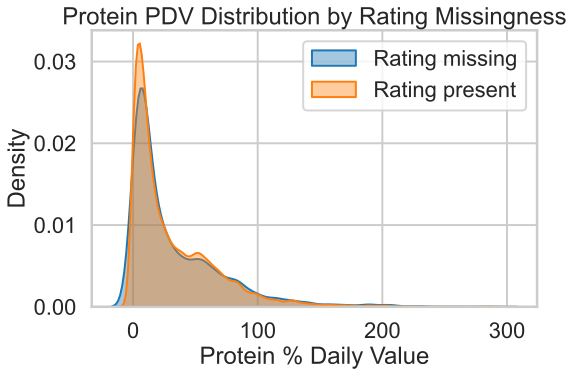

In [14]:
dff = df_missing_vals

X = 'protein_PDV'
Y = 'rating'

# Create missingness flag
dff['Y_missing'] = dff[Y].isna()

# Filter out NaN in protein_PDV
df_plot = dff[dff[X].notna()].copy()

# Boxplot using seaborn with a categorical x
plt.figure(figsize=(8,5))
sns.boxplot(data=df_plot, x='Y_missing', y=X, palette=['lightblue','lightcoral'])
plt.xticks([0,1], ['Rating present', 'Rating missing'])  # False=0, True=1
plt.ylabel('Protein % Daily Value')
plt.title('Distribution of Protein PDV by Rating Missingness')
plt.ylim(-10, 150) # Y-axis limited to 0–150% for clarity and thus extreme outliers beyond this range are not shown.
plt.show()

plt.figure(figsize=(8,5))
sns.kdeplot(data=df_plot[df_plot['Y_missing']], x=X, label='Rating missing', fill=True, alpha=0.4)
sns.kdeplot(data=df_plot[~df_plot['Y_missing']], x=X, label='Rating present', fill=True, alpha=0.4)
plt.xlabel('Protein % Daily Value')
plt.ylabel('Density')
plt.title('Protein PDV Distribution by Rating Missingness')
plt.legend()
plt.show()


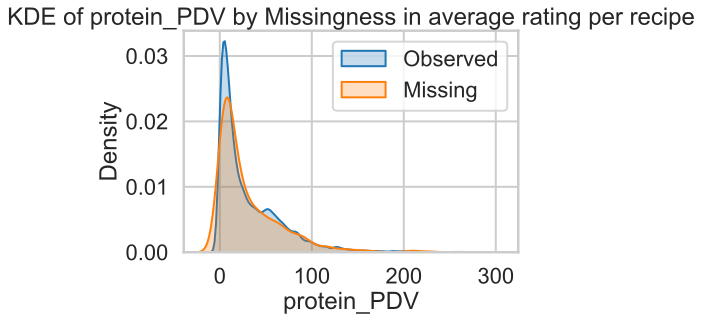

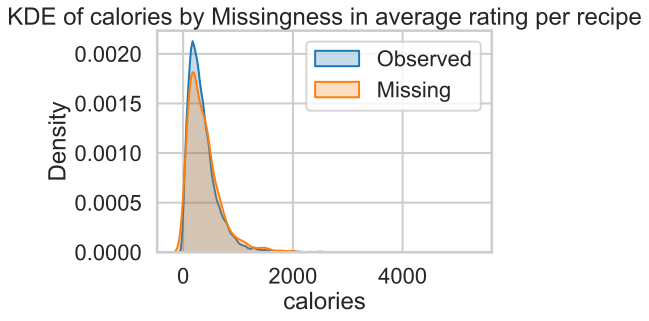

In [15]:
# Graph to show why KS is the appropriate Test Stat (May need to be removed after website creation)

import matplotlib.pyplot as plt
import seaborn as sns

def visualize_mar_kde(df, target_col, obs_col):
    """
    Visualize MAR using only KDE plots.
    Compares the distribution of obs_col for missing vs observed target_col values.
    """
    df = df.copy()
    df['missing_indicator'] = df[target_col].isna().astype(int)
    
    plt.figure(figsize=(6,4))
    sns.kdeplot(df.loc[df['missing_indicator']==0, obs_col], label='Observed', fill=True)
    sns.kdeplot(df.loc[df['missing_indicator']==1, obs_col], label='Missing', fill=True)
    plt.xlabel(obs_col)
    plt.ylabel('Density')
    plt.title(f'KDE of {obs_col} by Missingness in {target_col}')
    plt.legend()
    plt.show()


# Test 1: protein_PDV
visualize_mar_kde(df_missing_vals, target_col='average rating per recipe', obs_col='protein_PDV')

# Test 2: calories
visualize_mar_kde(df_missing_vals, target_col='average rating per recipe', obs_col='calories')


## Step 4: Hypothesis Testing

In [16]:
# TODO

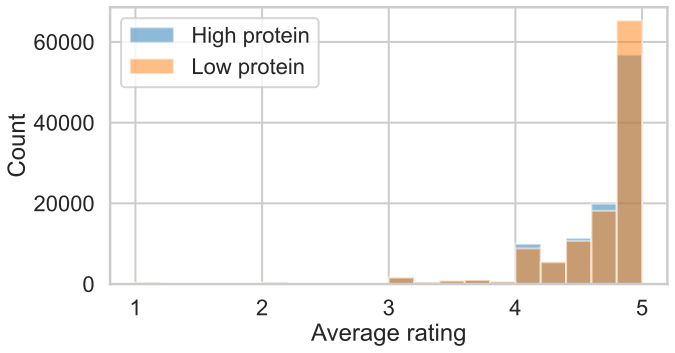

In [17]:
# Distribution of Protein Recipes Visual

# High-protein group
high = df_missing_vals[df_missing_vals['protein_PDV'] > df_missing_vals['protein_PDV'].median()]['average rating per recipe']

# Low-protein group
low = df_missing_vals[df_missing_vals['protein_PDV'] <= df_missing_vals['protein_PDV'].median()]['average rating per recipe']

plt.hist(high, bins=20, alpha=0.5, label='High protein')
plt.hist(low, bins=20, alpha=0.5, label='Low protein')
plt.xlabel('Average rating')
plt.ylabel('Count')
plt.legend()
plt.show()

Null Hypothesis: Recipes with higher protein content (higher protein_PDV) have similar ratings on average to recipes with lower protein content (lower protein_PDV).
Alternative Hypothesis: Recipes with higher protein content (higher protein_PDV) have ratings that differ from recipes with lower protein content (lower protein_PDV).
Observed ANOVA F-statistic: 26.237
Permutation test p-value = 0.0000


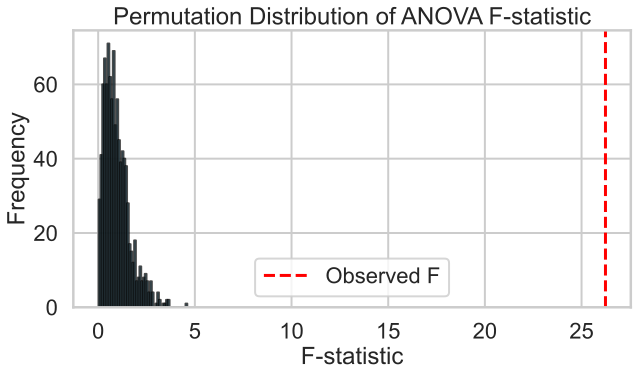

In [18]:
from scipy.stats import f_oneway

# Test Statistic: ANOVA F-statistic

print('Null Hypothesis: Recipes with higher protein content (higher protein_PDV) have similar ratings on average to recipes with lower protein content (lower protein_PDV).' \
'\nAlternative Hypothesis: Recipes with higher protein content (higher protein_PDV) have ratings that differ from recipes with lower protein content (lower protein_PDV).')

# Dataframe for Permutation Test 
df_permutation_test = dataframe_final.dropna(subset=['rating', 'protein_PDV'])

# Compute observed F-statistic
groups = [df_permutation_test[df_permutation_test['rating']==r]['protein_PDV'].values for r in sorted(df_permutation_test['rating'].unique())]
F_obs, _ = f_oneway(*groups)
print(f"Observed ANOVA F-statistic: {F_obs:.3f}")

# Permutation test
n_permutations = 1000
F_perm = []

ratings = df_permutation_test['rating'].values
protein = df_permutation_test['protein_PDV'].values

for _ in range(n_permutations):
    shuffled = np.random.permutation(ratings)
    shuffled_groups = [protein[shuffled==r] for r in sorted(df_permutation_test['rating'].unique())]
    F_perm.append(f_oneway(*shuffled_groups)[0])

F_perm = np.array(F_perm)
p_value = np.mean(F_perm >= F_obs)
print(f"Permutation test p-value = {p_value:.4f}")

# Visualization
plt.hist(F_perm, bins=50, alpha=0.7, color='skyblue', edgecolor='black')  # histogram bars
plt.axvline(F_obs, color='red', linestyle='dashed', linewidth=3, label='Observed F')  # darker, thicker line
plt.xlabel('F-statistic')
plt.ylabel('Frequency')
plt.title('Permutation Distribution of ANOVA F-statistic')
plt.legend()
plt.show()

## Step 5: Framing a Prediction Problem

In [31]:
# TODO
print('Prediction Problem: Predict the calories of a recipe, which was extracted from the original nutrition column of the dataframe, using engineered features or the protein_PDV and the rating of that recipe. This is a regression problem and not a classification problem since I will be predicting a numerical value.')
df_prediction = dataframe_final.copy()

Prediction Problem: Predict the calories of a recipe, which was extracted from the original nutrition column of the dataframe, using engineered features or the protein_PDV and the rating of that recipe. This is a regression problem and not a classification problem since I will be predicting a numerical value.


## Step 6: Baseline Model

In [20]:
# TODO

In [ ]:
# Move imports to the top
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer, mean_squared_error

numeric_features = ["protein_PDV", "rating"]

preprocess = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features)
    ]
)

pipeline = Pipeline([
    ("preprocess", preprocess),
    ("model", LinearRegression())
])

from sklearn.model_selection import train_test_split

X = dataframe_final[["protein_PDV", "rating"]]
y = dataframe_final["calories"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)

scoring = {
    'r2': 'r2',
    'mae': 'neg_mean_absolute_error',
    'rmse': make_scorer(mean_squared_error, squared=False)
}

cv_results = cross_validate(pipeline, X, y, cv=5, scoring=scoring)

print("\n=== 5-Fold Cross-Validation Performance ===")
print(f"Mean R²:   {cv_results['test_r2'].mean():.4f}")
print(f"Mean MAE:  {-cv_results['test_mae'].mean():.4f}")
print(f"Mean RMSE: {cv_results['test_rmse'].mean():.4f}")

y_pred


=== 5-Fold Cross-Validation Performance ===
Mean R²:   0.4855
Mean MAE:  136.5334
Mean RMSE: 205.4506


/Users/nathanjoseph/.local/share/mamba/envs/dsc80/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.

/Users/nathanjoseph/.local/share/mamba/envs/dsc80/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.

/Users/nathanjoseph/.local/share/mamba/envs/dsc80/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.

/Users/nathanjoseph/.local/share/mamba/envs/dsc80/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning:

'squared' is depr

array([837.33, 228.1 , 262.91, ..., 181.68, 686.47, 332.54])

In [22]:
# Move import to the top
from sklearn.metrics import r2_score

y_pred = pipeline.predict(X_test)

r2 = r2_score(y_test, y_pred)

print("R²:", r2)

R²: 0.48330246774093943


## Step 7: Final Model

In [ ]:
# TODO

In [37]:
# Move imports to the top
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error


df_finalmodel = dataframe_final.copy()
df_finalmodel = df_finalmodel[df_finalmodel["minutes"] > 0]
df_finalmodel = df_finalmodel[df_finalmodel["n_steps"] > 0]
df_finalmodel["protein_density"] = df_finalmodel["protein_PDV"] / df_finalmodel["minutes"]
df_finalmodel["rating_per_step"] = df_finalmodel["rating"] / df_finalmodel["n_steps"]

feature_cols = ["protein_density", "rating_per_step"]
X = df_finalmodel[feature_cols]
y = df_finalmodel["calories"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

preproc = ColumnTransformer(
    transformers=[
        ("scale", StandardScaler(), feature_cols)
    ]
)
pipeline = Pipeline([
    ("preprocess", preproc),
    ("model", RandomForestRegressor(random_state=42))
])

param_grid = {
    "model__n_estimators": [100, 200],
    "model__max_depth": [5, 10, None],
    "model__min_samples_split": [2, 5]
}

grid = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,
    scoring="r2",
    n_jobs=-1
)

grid.fit(X_train, y_train)

best_model = grid.best_estimator_
print("Best Parameters:", grid.best_params_)

y_pred = best_model.predict(X_test)

print("\n=== Final Model Performance ===")
print(f"R²:  {r2_score(y_test, y_pred):.4f}")
print(f"MAE: {mean_absolute_error(y_test, y_pred):.4f}")
print(f"RMSE:{mean_squared_error(y_test, y_pred, squared=False):.4f}")


Best Parameters: {'model__max_depth': None, 'model__min_samples_split': 5, 'model__n_estimators': 200}

=== Final Model Performance ===
R²:  0.5417
MAE: 118.3965
RMSE:193.8043


/Users/nathanjoseph/.local/share/mamba/envs/dsc80/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.



## Step 8: Fairness Analysis

In [ ]:
# TODO

RMSE (before 2011): 161.88
RMSE (2011 or later): 158.25
Observed difference (X - Y): 3.64
Permutation test p-value: 0.0090


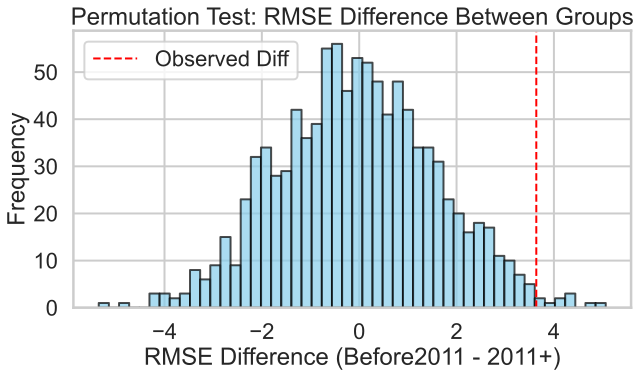

In [ ]:
df_fair = df_finalmodel.copy()

group_split = pd.Timestamp('2011-01-01')
group_X = df_fair['date'] < group_split
group_Y = df_fair['date'] >= group_split

X_fair = df_fair[feature_cols]
y_fair = df_fair['calories']

y_pred = best_model.predict(X_fair)

def rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred)**2))

rmse_X = rmse(y_fair[group_X], y_pred[group_X])
rmse_Y = rmse(y_fair[group_Y], y_pred[group_Y])
rmse_obs = rmse_X - rmse_Y

print(f"RMSE (before 2011): {rmse_X:.2f}")
print(f"RMSE (2011 or later): {rmse_Y:.2f}")
print(f"Observed difference: {rmse_X - rmse_Y:.2f}")

n_permutations = 1000
rmse_diff_perm = []

y_true = y_fair.values
group_labels = np.array([0 if m else 1 for m in group_X])

for _ in range(n_permutations):
    np.random.shuffle(group_labels)
    rmse_X_perm = rmse(y_true[group_labels == 0], y_pred[group_labels == 0])
    rmse_Y_perm = rmse(y_true[group_labels == 1], y_pred[group_labels == 1])
    rmse_diff_perm.append(rmse_X_perm - rmse_Y_perm)

rmse_diff_perm = np.array(rmse_diff_perm)

# p-value: probability that permuted difference >= observed difference
p_value = np.mean(rmse_diff_perm >= (rmse_obs))

print(f"Permutation test p-value: {p_value:.4f}")

import matplotlib.pyplot as plt

plt.hist(rmse_diff_perm, bins=50, color='skyblue', edgecolor='black', alpha=0.7)
plt.axvline(rmse_X - rmse_Y, color='red', linestyle='dashed', linewidth=2, label='Observed Diff')
plt.xlabel('RMSE Difference (Before2011 - 2011+)')
plt.ylabel('Frequency')
plt.title('Permutation Test: RMSE Difference Between Groups')
plt.legend()
plt.show()
print('Since the p-value < 0.05, the model performs worse for recipes submitted before 2011 than for recipes submitted in 2011 or later.')
